In [2]:
import pandas as pd
import numpy as np
from graph_data import GraphData
from IPython.display import display

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from dtaidistance import clustering

import matplotlib.pyplot as plt 


In [7]:

path = "/home/vast/MC1/data/"

nodes_file_template = "CGCS-Template-NodeTypes.csv"
edges_file_template = "CGCS-Template"

graphs={}

graph = GraphData()
graph.read_data(nodes_file=nodes_file_template, edges_file=edges_file_template+".csv", path=path, path_nodes=path)
graphs[edges_file_template] = graph

stList = graph.edges.stType.unique()
nodes_file = "CGCS-GraphData-NodeTypes.csv"
graph_names = ["Q1-Graph1", "Q1-Graph2", "Q1-Graph3", "Q1-Graph4", "Q1-Graph5"]

for name in graph_names:
    graph = GraphData()
    graph.read_data(nodes_file=nodes_file, edges_file=name+".csv", path=path, path_nodes=path, stList=stList)
    graph.scaleStType = graphs[edges_file_template].scaleStType
    graph.scaleStType = graphs[edges_file_template].scaleStType
    graphs[name] = graph

In [8]:
time_series = {}
array_time_series = {}
group_by_source = {}
sources_graph = {}
array_time_series_global = []

for name, graph in graphs.items():
    time_series[name] = {}
    array_time_series[name] = []
    # graph.edges_no_financial.set_index('Source')
    
    mask = graph.edges_no_financial.eType!='Author-of'
#     mask = graph.edges_no_financial.stType=='Person-> Person'
        
    time_series_g = graph.edges_no_financial[mask].resample('D', on='Time').count().Time
    array_time_series_global.append(time_series_g.values.astype('float') )

    group_by_source[name] = graph.edges_no_financial[mask].groupby('Source')
    
    sources_graph[name] = group_by_source[name].groups.keys()
    
    for s in sources_graph[name]:
        time_series[name][s] = group_by_source[name][["Time"]].get_group(s).resample('D', on='Time').count()
        array_time_series[name].append(time_series[name][s].Time.values.astype('float'))
        
    
    

In [9]:
template_name = edges_file_template
distance_matrices = {}

for name in graph_names:
    print(name)
    
    series_t_g = array_time_series[template_name] + array_time_series[name]
    block = ((0, len(array_time_series[template_name])),
               (len(array_time_series[template_name]), len(series_t_g)))
    
    dm = dtw.distance_matrix_fast(series_t_g, block=block, window=4*7, psi=2)
    distance_matrices[name] = dm[block[0][0]:block[0][1], block[1][0]:block[1][1]]


Q1-Graph1
Q1-Graph2
Q1-Graph3
Q1-Graph4
Q1-Graph5


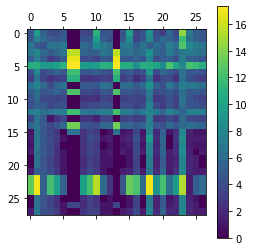

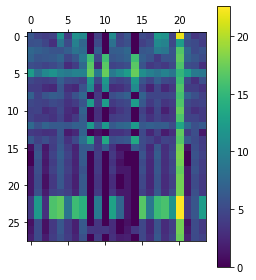

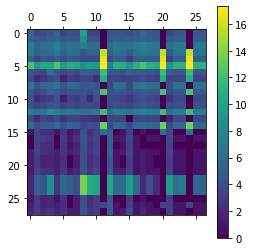

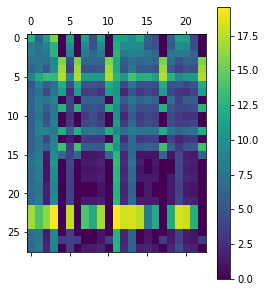

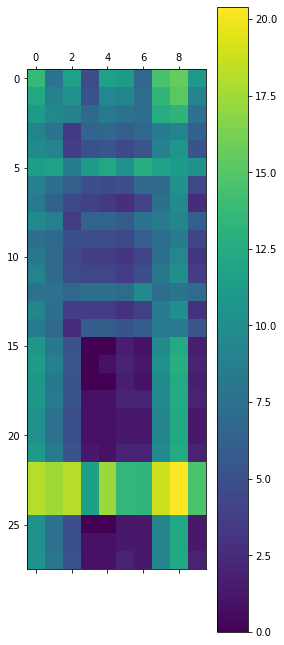

In [10]:
for name in graph_names:
    plt.matshow(distance_matrices[name])
    plt.colorbar()

In [11]:
import csv

for name in graph_names:
    with open(f'ts_distances/dtw_{name}.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        i = 0
        for sn in sources_graph[template_name]:
            j=0
            for gn in sources_graph[name]:
                row = [sn, gn, distance_matrices[name][i][j]]
                writer.writerow(row)
                j += 1
            i += 1

FileNotFoundError: [Errno 2] No such file or directory: 'ts_distances/dtw_Q1-Graph1.csv'

(<Figure size 720x720 with 4 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f56e8aedf50>])

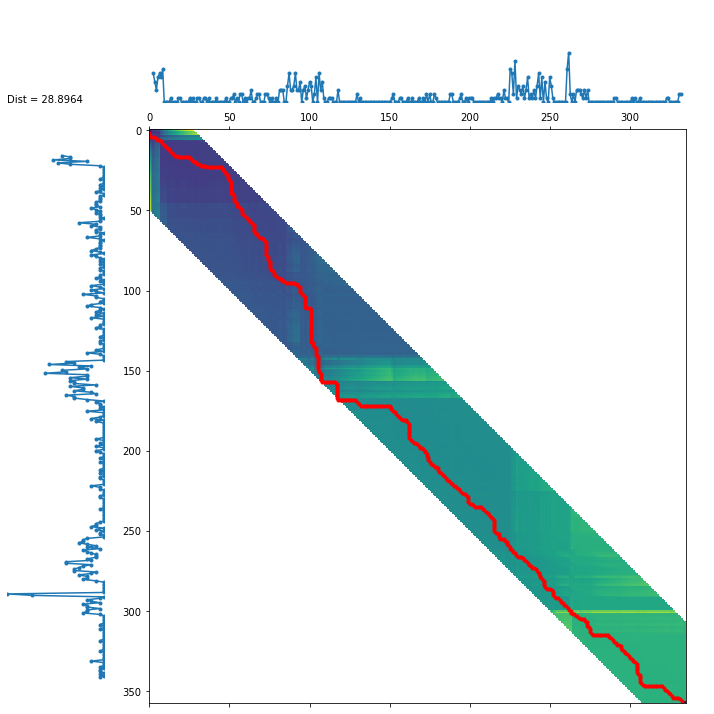

In [12]:

# path = dtw.warping_path(array_time_series[0], array_time_series[1])
s1 = array_time_series_global[0]
s2 = array_time_series_global[1]
distance = dtw.distance_fast(s1, s2)
distance, paths = dtw.warping_paths(s1, s2, window=7*4, psi=2)
dtwvis.plot_warpingpaths(s1, s2, paths)

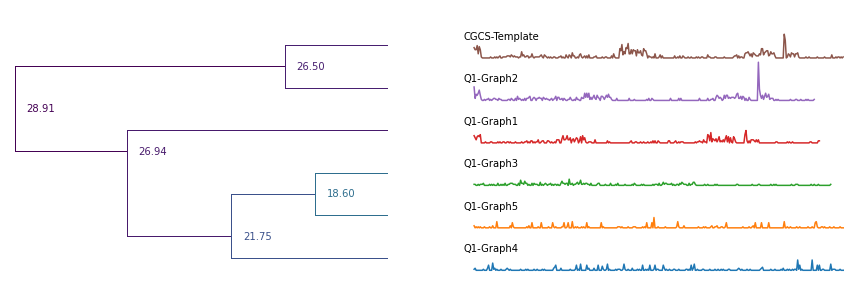

In [22]:
import matplotlib.pyplot as plt 

# Custom Hierarchical clustering
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {'window': 7*4, 'psi': 2})
model2 = clustering.HierarchicalTree(model1)
cluster_idx = model2.fit(array_time_series_global)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
dtw_plot = model2.plot(axes=ax, show_ts_label=list(graphs.keys()),
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)
fig.savefig('hierarchical.svg')

AttributeError: 'NoneType' object has no attribute 'savefig'

In [ ]:

model1_n = clustering.Hierarchical(dtw.distance_matrix, {})
model2_n = clustering.HierarchicalTree(model1_n)
cluster_idx_n = model2_n.fit(array_time_series)
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 30))
model2_n.plot(axes=ax, show_ts_label=list_names,
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)